# Long-Term Trend Following Strategy
## 12-Month Time-Series Momentum with Volatility Targeting

This notebook implements and evaluates a classic long-term trading strategy using historical stock data.

### Strategy Summary
- Use **12-month momentum** to determine market regime
- Go long when momentum is positive
- Stay in cash when momentum is negative
- Apply **volatility targeting** to stabilize risk
- Use **weekly data** to reduce noise and turnover

The strategy is backtested on historical stock data using Yahoo Finance.

## 1. Import Libraries and Configure Environment

In [12]:
%pip install yfinance --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["axes.grid"] = True

## 2. Download Historical Price Data

We use weekly adjusted close prices to align with a long-term investment horizon.

In [14]:
ticker = "SPY"  # S&P 500 ETF
start_date = "2000-01-01"

data = yf.download(ticker, start=start_date, auto_adjust=True)
weekly = data.resample("W-FRI").last()

weekly.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2000-01-07,91.813911,91.813911,88.231122,88.388607,8066500
2000-01-14,92.581696,92.896666,91.951754,92.306096,7437300
2000-01-21,90.987144,91.656457,90.750916,91.656457,6244800
2000-01-28,85.593246,88.231125,85.376704,87.837412,11916200
2000-02-04,89.825661,90.711515,89.530376,90.199688,4925400


## 3. Price Chart (Baseline Reference)

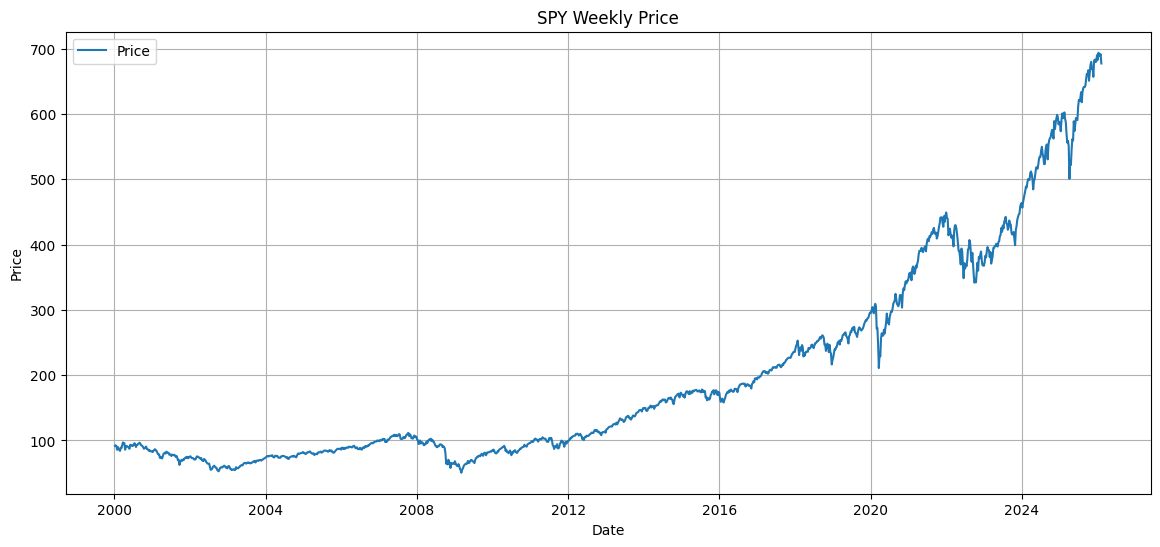

In [15]:
plt.plot(weekly.index, weekly["Close"], label="Price")
plt.title(f"{ticker} Weekly Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.savefig("spy_weekly_price.png")
plt.show()

## 4. 12-Month Momentum Calculation

Momentum is defined as the percentage return over the past 12 months (52 weeks).

In [16]:
lookback = 52
weekly["Momentum"] = weekly["Close"].pct_change(lookback)

weekly[["Close", "Momentum"]].dropna().head()

Price,Close,Momentum
Ticker,SPY,
Date,,
2001-01-05,82.236351,-0.104315
2001-01-12,84.026703,-0.092405
2001-01-19,85.309761,-0.062398
2001-01-26,86.493423,0.010517
2001-02-02,85.809090,-0.044715


## 5. Trading Signal

- Long when momentum > 0
- Cash when momentum ≤ 0

In [17]:
weekly["Signal"] = np.where(weekly["Momentum"] > 0, 1, 0)
weekly["Signal"] = weekly["Signal"].shift(1)  # avoid lookahead bias

## 6. Volatility Targeting

We scale exposure so that the strategy targets a fixed annual volatility.

In [18]:
target_vol = 0.10  # 10% annual volatility
weekly["Returns"] = weekly["Close"].pct_change()

rolling_vol = weekly["Returns"].rolling(52).std() * np.sqrt(52)
weekly["Position"] = (target_vol / rolling_vol) * weekly["Signal"]
weekly["Position"] = weekly["Position"].clip(0, 1)

weekly[["Signal", "Position"]].dropna().head()

Price,Signal,Position
Ticker,,
Date,,
2001-01-05,0.0,0.000000
2001-01-12,0.0,0.000000
2001-01-19,0.0,0.000000
2001-01-26,0.0,0.000000
2001-02-02,1.0,0.486975


## 7. Strategy Returns Calculation

In [19]:
weekly["Strategy_Returns"] = weekly["Position"] * weekly["Returns"]
weekly["Cumulative_Strategy"] = (1 + weekly["Strategy_Returns"]).cumprod()
weekly["Cumulative_BuyHold"] = (1 + weekly["Returns"]).cumprod()

In [20]:
weekly_clean = weekly.dropna().copy()

## 8. Strategy vs Buy & Hold

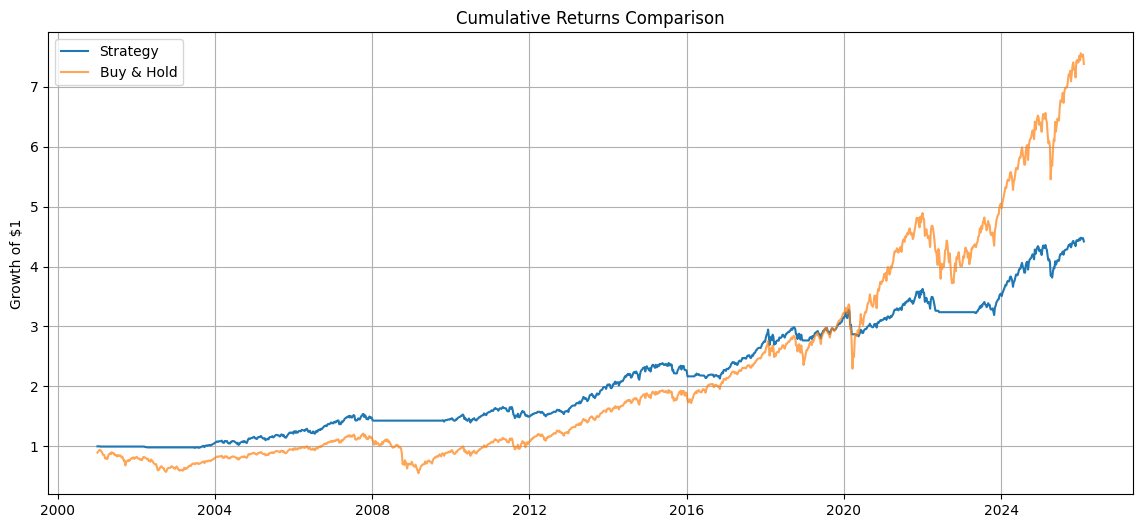

In [21]:
plt.plot(
    weekly_clean.index,
    weekly_clean["Cumulative_Strategy"],
    label="Strategy"
)

plt.plot(
    weekly_clean.index,
    weekly_clean["Cumulative_BuyHold"],
    label="Buy & Hold",
    alpha=0.7
)

plt.title("Cumulative Returns Comparison")
plt.ylabel("Growth of $1")
plt.legend()
plt.savefig("cumulative_returns_comparison.png")
plt.show()

## 9. Buy and Sell Signals on Price Chart

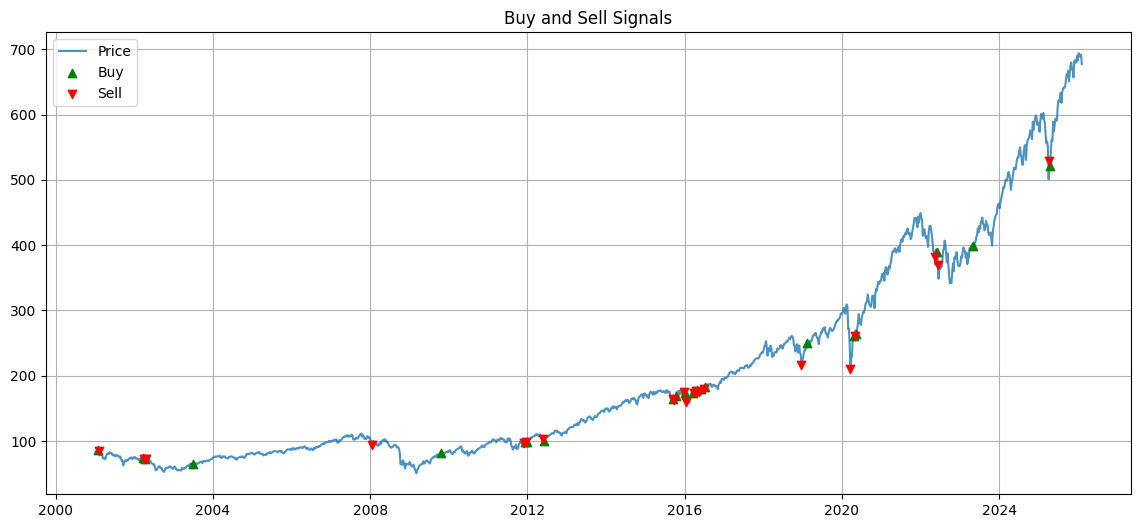

In [22]:
buy_signals = weekly_clean[
    (weekly_clean["Signal"] == 1) &
    (weekly_clean["Signal"].shift(1) == 0)
]

sell_signals = weekly_clean[
    (weekly_clean["Signal"] == 0) &
    (weekly_clean["Signal"].shift(1) == 1)
]

plt.plot(
    weekly_clean.index,
    weekly_clean["Close"],
    label="Price",
    alpha=0.8
)

plt.scatter(
    buy_signals.index,
    buy_signals["Close"],
    marker="^",
    color="green",
    label="Buy",
    zorder=3
)

plt.scatter(
    sell_signals.index,
    sell_signals["Close"],
    marker="v",
    color="red",
    label="Sell",
    zorder=3
)

plt.title("Buy and Sell Signals")
plt.legend()
plt.savefig("buy_sell_signals.png")
plt.show()

## 10. Drawdown Analysis

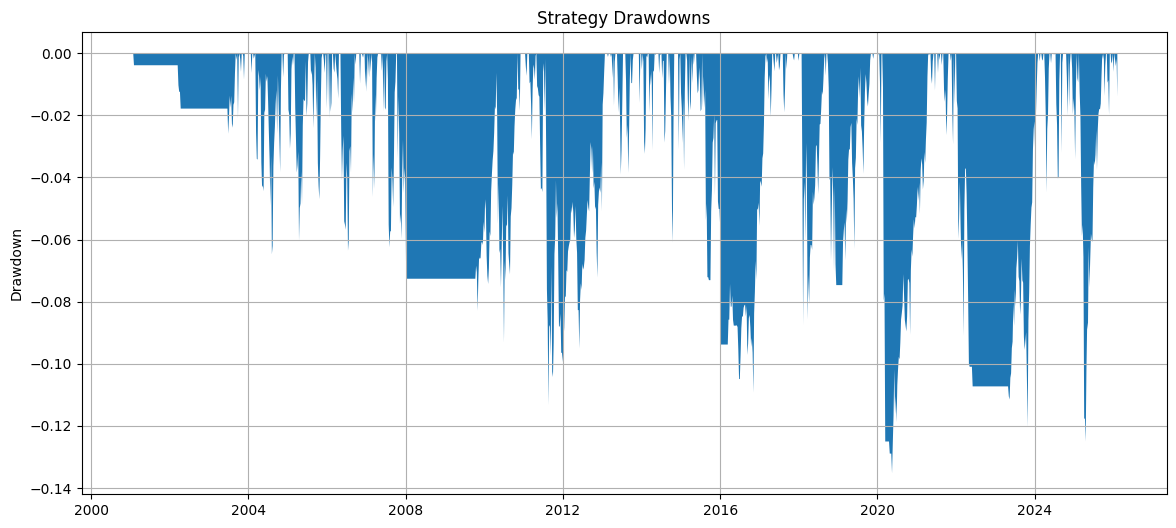

In [23]:
rolling_max = weekly_clean["Cumulative_Strategy"].cummax()
drawdown = weekly_clean["Cumulative_Strategy"] / rolling_max - 1

plt.fill_between(drawdown.index, drawdown, 0)
plt.title("Strategy Drawdowns")
plt.ylabel("Drawdown")
plt.savefig("strategy_drawdowns.png")
plt.show()

## 11. Performance Summary

In [24]:
def performance_metrics(returns):
    ann_return = (1 + returns.mean()) ** 52 - 1
    ann_vol = returns.std() * np.sqrt(52)
    sharpe = ann_return / ann_vol

    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    max_dd = (cumulative / rolling_max - 1).min()

    return ann_return, ann_vol, sharpe, max_dd


metrics = pd.DataFrame(
    [
        performance_metrics(weekly_clean["Returns"]),
        performance_metrics(weekly_clean["Strategy_Returns"])
    ],
    columns=["Annual Return", "Annual Volatility", "Sharpe Ratio", "Max Drawdown"],
    index=["Buy & Hold", "Strategy"]
)

metrics

,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
Buy & Hold,0.103782,0.176047,0.589514,-0.546130
Strategy,0.064627,0.085261,0.757993,-0.135246
